# Predicting University Admission Using Logistic Regression

In this project, a logistic regression model is implemented to predict university admission outcomes based on applicants’ exam results.
Using historical admission data, the model estimates the probability of admission given scores from two exams.
Each data sample consists of two exam scores along with a binary admission decision, and the dataset is used to train a binary classification model that learns the relationship between exam performance and admission likelihood.

The following section loads the dataset and its corresponding labels.

In [1242]:
import pandas as pd
import numpy as np

In [1243]:
students = pd.read_csv("../data/student_exam_scores.csv", names=["First_Exam", "Second_Exam", "Admission_Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(students[["First_Exam", "Second_Exam"]])
y = np.array(students["Admission_Status"])

# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 100


### 🔍 Data Preview  
Displaying the first rows to verify the structure and ensure the labels (0/1) are correctly loaded.

In [1244]:
students.head()

,First_Exam,Second_Exam,Admission_Status
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### 1. Visualizing the data

Before implementing the logistic regression model, it is important to explore and visualize the dataset.
The dataset is visualized using the matplotlib library to examine the relationship between exam scores and admission outcomes.

In [1245]:
import matplotlib.pyplot as plt

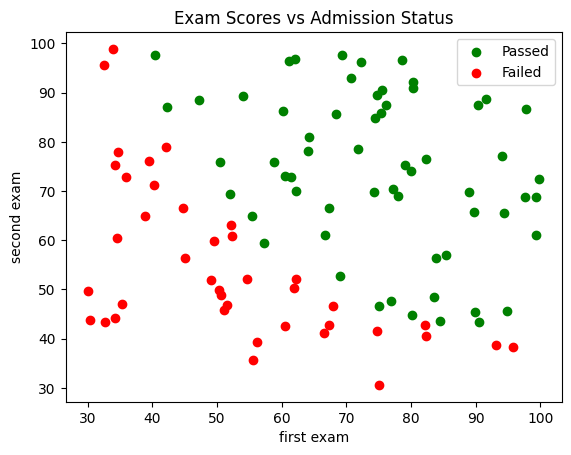

In [1246]:
# Separate students based on admission status
passed_students = students[students["Admission_Status"] == 1]
failed_students = students[students["Admission_Status"] == 0]

# Plot exam scores: green for passed, red for failed
plt.scatter(passed_students["First_Exam"], passed_students["Second_Exam"], color="green", label="Passed")
plt.scatter(failed_students["First_Exam"], failed_students["Second_Exam"], color="red", label="Failed")

# Add title, axis labels, and legend to visualize the relationship between exam scores and admission
plt.title("Exam Scores vs Admission Status")
plt.xlabel("first exam")
plt.ylabel("second exam")
plt.legend()
plt.show()

### 2. Implementation

#### 2.1 Sigmoid Function

The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x) $$

where $g$ is the sigmoid function. The sigmoid function is defined as:

$$ g(z) = \frac{1}{1+e^{-z}} $$

In this project, the first step is to implement the `sigmoid` function, which will be used throughout the program.  
The function should support scalar, vector, and matrix inputs, applying the sigmoid function element-wise.  

This function serves as the foundation for computing probabilities in logistic regression.


In [1247]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """

    g = 1 / (1 + np.exp(-z))
    return g

#### 2.2 Cost function and gradient

Now, the cost function and gradient for logistic regression are implemented.  
Before proceeding, an intercept term (bias) is added to the feature matrix \(X\).



In [1248]:
# --- Add intercept term (bias) ---
X = np.concatenate([np.ones((len(X), 1)), X], axis=1)  # column of ones for theta_0

# --- Standardize features (exclude bias column) ---
# Compute mean and standard deviation of each feature (columns 1 and 2)
mean = X[:, 1:].mean(axis=0)
std = X[:, 1:].std(axis=0)

# Apply standardization
X[:, 1:] = (X[:, 1:] - mean) / std


The parameter $\theta_0$ represents the bias term in the model's weights.  

In this project, the function `cost_function` is implemented to compute the cost value, and `gradient_descent` is defined to return the gradient.  

The logistic regression cost function is defined as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$, with the $j^{th}$ element (for $j = 0, 1, \cdots , n$) given by:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Although the gradient formula looks similar to the linear regression gradient, it differs because the hypothesis function $h_\theta(x)$ is defined differently in logistic regression.


In [1249]:
def cost_function(theta, X, y):
    """
    Compute cost_function for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.
    """
    # 1. Prediction: Calculate the probability (h) for all samples at once
    h = sigmoid(X.dot(theta))
    
    # 2. Stability: Prevent log(0) which results in NaN (Not a Number)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    
    # 3. Vectorized Cost Calculation: 
    term1 = y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    
    J = - (1 / m) * np.sum(term1 + term2)
    
    return J

In [1250]:
def gradient_descent(theta, X, y):
    """
    Compute gradient_descent for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    # 1. Prediction: Compute probabilities using the sigmoid of X*theta
    h = sigmoid(X.dot(theta))
    
    # 2. Vectorized Gradient Calculation:
    grad = (1 / m) * X.T.dot(h - y)
    
    return grad

### Calculating the Optimal θ Using Stochastic Gradient Descent


In [1251]:

def train_using_sgd(theta, X, y, learning_rate=0.05, epochs=500):
    """
    Perform stochastic gradient descent to train the logistic regression model.
    """
    m = X.shape[0]  # number of samples
    for epoch in range(epochs):
        # Shuffle data at each epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(m):
            xi = X_shuffled[i]
            yi = y_shuffled[i]
            
            # Compute prediction for single sample
            h = sigmoid(np.dot(xi, theta))
            
            # Gradient for this sample
            grad = (h - yi) * xi
            
            # Update parameters
            theta -= learning_rate * grad

    return theta

# Initialize theta and train
theta = np.zeros(X.shape[1])
theta_optimized = train_using_sgd(theta, X, y)


### Plotting the Decision Boundary of the Logistic Regression Model Trained with Gradient Descent


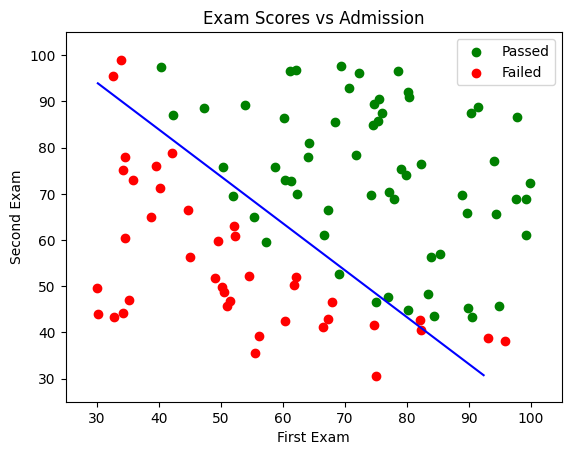

In [1252]:
# Generate a grid of points
x1 = np.linspace(students["First_Exam"].min(), students["First_Exam"].max(), 200)
x2 = np.linspace(students["Second_Exam"].min(), students["Second_Exam"].max(), 200)
xx1, xx2 = np.meshgrid(x1, x2)

# Flatten and standardize manually using the mean and std from training
grid = np.c_[xx1.ravel(), xx2.ravel()]
grid_scaled = (grid - mean) / std  # standardize like training
grid_scaled = np.c_[np.ones(grid_scaled.shape[0]), grid_scaled]  # add bias

# Compute probabilities
probs = sigmoid(grid_scaled.dot(theta_optimized)).reshape(xx1.shape)

# Plot
plt.scatter(passed_students["First_Exam"], passed_students["Second_Exam"], color="green", label="Passed")
plt.scatter(failed_students["First_Exam"], failed_students["Second_Exam"], color="red", label="Failed")

# Draw decision boundary (0.5 contour)
plt.contour(xx1, xx2, probs, levels=[0.5], colors='blue')

# Extend axis limits to better display high scores
plt.xlim(25, 105)
plt.ylim(25, 105)

plt.title("Exam Scores vs Admission")
plt.xlabel("First Exam")
plt.ylabel("Second Exam")
plt.legend()
plt.show()


#### 2.3 Evaluating logistic regression

After learning the model parameters, the trained logistic regression model is used to predict the probability of admission for a specific student. In particular, we compute and print the admission probability for a student who scored 53 on Exam 1 and 94 on Exam 2.

In [1253]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.
    """
    predicted = np.zeros(m)
    predicted = np.round(sigmoid(X.dot(theta)))

    return predicted

### Predicting Admission for a New Student
We apply the trained model to a student with scores of **53** and **94**. 
The process includes feature scaling (standardization), adding the bias term, and computing the final prediction.

In [1254]:
# Define student scores: Exam 1 = 53, Exam 2 = 94
new_student = np.array([[53, 94]])

# Standardize features using the training mean and std
new_student_scaled = (new_student - mean) / std

# Add bias term (intercept)
new_student_final = np.c_[np.ones(1), new_student_scaled]

# Predict outcome (0 or 1)
prediction = predict(theta_optimized, new_student_final)

# Display result
result = "Pass" if prediction[0] == 1 else "Fail"
print(f"Prediction for [53, 94]: {result}")

Prediction for [53, 94]: Pass


### Evaluating Model Accuracy
To evaluate how well our model performs, we compare its predictions against the actual labels from the dataset. 
The accuracy is calculated as the percentage of correct predictions out of the total number of samples.

In [1255]:
def accuracy(y_pred, y):
    """
    check prediction accuracy with comparison between predict and actual value
    if two parameter(predicted and actual value) are equal diff will be 0 and
    otherwise will be 1. count of nonzero devided by len of diff is errors. 1 minus
    error is our prediction accuracy

    Parameters
    ----------
    y_pred : array_like
        Predicted values that output of predict function.

    y : array_like
        Actual value of data, (Labels)

    Returns
    -------
    number : float
        model accuracy percentage
    """
    diff = y_pred - y
    errors_amount = np.count_nonzero(diff)
    accuracy = 1 - errors_amount / len(diff)
    return accuracy

In [1256]:
# 1. Manually scale the original features (First_Exam and Second_Exam)
# We use the same 'mean' and 'std' calculated during training
X_original = students[["First_Exam", "Second_Exam"]].values
X_scaled = (X_original - mean) / std

# 2. Add the intercept (bias) column of ones
X_full = np.c_[np.ones(X_scaled.shape[0]), X_scaled]

# 3. Generate predictions for the entire dataset
y_pred = predict(theta_optimized, X_full)

# 4. Calculate accuracy using your accuracy function
# 'y' should be the actual labels (e.g., students["Admission_Status"])
model_accuracy = accuracy(y_pred, y)

# 5. Print the accuracy percentage
print(f"Model Training Accuracy: {model_accuracy * 100:.2f}%")

Model Training Accuracy: 90.00%


To evaluate the performance of the model, we plot the Receiver Operating Characteristic (ROC) curve and compute the Area Under the Curve (AUC), which summarizes the model’s ability to distinguish between admitted and non-admitted students across different decision thresholds.

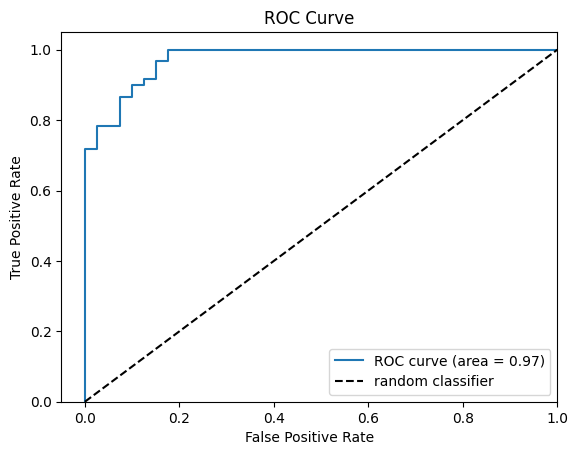

In [1257]:
from sklearn.metrics import roc_curve, auc

y_pred = sigmoid(np.dot(X, theta_optimized))
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='random classifier')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

